In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import numpy as np
import cProfile
import pstats
import io
import psutil

torch.manual_seed(8)

import matplotlib.pyplot as plt
import math

import time
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = False
torch.nn.Module.dump_patches = True
import copy
import pandas as pd

from rdkit import Chem
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy

#then import my own modules
from attfp_torch_utils import Fingerprint, CosineAnnealingWarmRestartsModified
from featurer import save_smiles_dicts, get_smiles_dicts, get_smiles_array

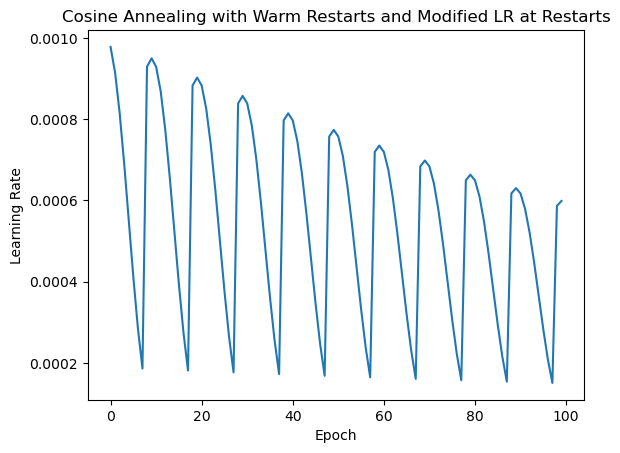

In [2]:


# Parameters
initial_lr = 1e-3
factor = 0.95  # Factor by which to multiply the learning rate at each restart
T_0 = 10  # Period of each restart

# Optimizer
optimizer = optim.AdamW([torch.zeros(3, requires_grad=True)], lr=initial_lr)

# Scheduler
scheduler = CosineAnnealingWarmRestartsModified(optimizer, T_0=T_0, factor=factor, eta_min=initial_lr * 0.1)

# Simulation loop
lr_rates = []
for epoch in range(100):
    optimizer.step()
    scheduler.step(epoch)
    lr_rates.append(optimizer.param_groups[0]['lr'])

# Plotting

# Plotting
plt.plot(lr_rates)
plt.title('Cosine Annealing with Warm Restarts and Modified LR at Restarts')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()


In [3]:
random_seed = 108 
start_time = str(time.ctime()).replace(':','-').replace(' ','-')

batch_size = 192
epochs = 200

p_dropout= 0.05
fingerprint_dim = 192
minGRU=False
weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 2

In [4]:
start_time

'Sat-Oct-26-18-20-20-2024'

In [5]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list



number of all smiles:  1128
number of successfully processed smiles:  1128


In [6]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

not processed items


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,cano_smiles
934,Methane,-0.636,0,16.043,0,0,0,0.0,-0.9,C,C


In [7]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(len(test_df),sorted(test_df.cano_smiles.values))


In [8]:
test_df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,cano_smiles
0,1-Chlorobutane,-1.940,1,92.569,0,0,2,0.00,-2.03,CCCCCl,CCCCCl
1,"2,6-Dimethylphenol",-2.589,1,122.167,1,1,0,20.23,-1.29,Cc1cccc(C)c1O,Cc1cccc(C)c1O
2,RTI 24,-4.423,1,273.723,1,3,1,45.23,-5.36,CCN2c1cc(Cl)ccc1NC(=O)c3cccnc23,CCN1c2cc(Cl)ccc2NC(=O)c2cccnc21
3,1-Dodecanol,-3.523,1,186.339,1,0,10,20.23,-4.80,CCCCCCCCCCCCO,CCCCCCCCCCCCO
4,3-Pentanol,-0.970,1,88.150,1,0,2,20.23,-0.24,CCC(O)CC,CCC(O)CC
...,...,...,...,...,...,...,...,...,...,...,...
108,p-Hydroxybenzaldehyde,-2.003,1,122.123,1,1,1,37.30,-0.96,Oc1ccc(C=O)cc1,O=Cc1ccc(O)cc1
109,Propyl propanoate,-1.545,1,116.160,0,0,3,26.30,-1.34,CCCCC(=O)OC,CCCCC(=O)OC
110,Methylcyclopentane,-2.452,1,84.162,0,1,0,0.00,-3.30,CC1CCCC1,CC1CCCC1
111,Dimethyldisulfide,-1.524,1,94.204,0,0,1,0.00,-1.44,CSSC,CSSC


In [9]:


# Set the device to MPS (Metal Performance Shaders) if available, otherwise use CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Assume canonical_smiles_list and feature_dicts are already defined
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]], feature_dicts)
print(x_atom.shape)
print(x_bonds.shape)
print(x_atom_index.shape)
print(x_bond_index.shape)
print(x_mask.shape)



num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

# Move your model to MPS
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout, minGRU=minGRU).to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), 10**-2.5, weight_decay=10**-5)

"""
# Print model parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
"""

def train(model, dataset, optimizer, loss_function, epoch=0, shuffle=True):
    model.train()
    valList = np.arange(0, dataset.shape[0])
    if shuffle:
        np.random.seed(epoch)
        np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i + batch_size]
        batch_list.append(batch)

    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch, :]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list, feature_dicts)

        # Move data to the MPS device
        x_atom = torch.Tensor(x_atom).to(device)
        x_bonds = torch.Tensor(x_bonds).to(device)
        x_atom_index = torch.LongTensor(x_atom_index).to(device)
        x_bond_index = torch.LongTensor(x_bond_index).to(device)
        x_mask = torch.Tensor(x_mask).to(device)
        y_val = torch.Tensor(y_val).to(device).view(-1, 1)

        # Forward pass
        atoms_prediction, mol_prediction = model(x_atom, x_bonds, x_atom_index, x_bond_index, x_mask)

        # Backpropagation
        model.zero_grad()
        loss = loss_function(mol_prediction, y_val)
        loss.backward()
        optimizer.step()


def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0, dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i + batch_size]
        batch_list.append(batch)

    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch, :]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list, feature_dicts)

        # Move data to the MPS device
        x_atom = torch.Tensor(x_atom).to(device)
        x_bonds = torch.Tensor(x_bonds).to(device)
        x_atom_index = torch.LongTensor(x_atom_index).to(device)
        x_bond_index = torch.LongTensor(x_bond_index).to(device)
        x_mask = torch.Tensor(x_mask).to(device)
        y_val = torch.Tensor(y_val).to(device).view(-1, 1)

        # Forward pass
        atoms_prediction, mol_prediction = model(x_atom, x_bonds, x_atom_index, x_bond_index, x_mask)
        
        # Compute losses
        MAE = F.l1_loss(mol_prediction, y_val, reduction='none')
        MSE = F.mse_loss(mol_prediction, y_val, reduction='none')

        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())

    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()





(1, 56, 39)
(1, 63, 10)
(1, 56, 6)
(1, 56, 6)
(1, 56)


In [10]:

# Parameters
factor = 0.95  # Factor by which to multiply the learning rate at each restart
T_0 = 10  # Period of each restart

scheduler = CosineAnnealingWarmRestartsModified(optimizer, T_0=T_0, factor=factor, eta_min=0.01 * 10**-2.5)


# Training loop
best_param = {}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(200):
    st = time.time()

    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
    test_MAE, test_MSE = eval(model, test_df)
    #test_MAE = 0
    #test_MSE = 0

    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 0.35:
            torch.save(model, 'saved_models/model_' + prefix_filename + '_' + start_time + '_' + str(epoch) + '.pt')
    if (epoch - best_param["train_epoch"] >8) and (epoch - best_param["valid_epoch"] >10):        
        break
        
    train(model, train_df, optimizer, loss_function, epoch=epoch, shuffle=True)
    scheduler.step(epoch)
    tt = time.time()-st

    print("epoch:",epoch, ", rmse train: ",np.sqrt(train_MSE),', rmse valid: ', np.sqrt(valid_MSE), ', rmse test: ', np.sqrt(test_MSE), ", time: ",tt, ', lr: ', optimizer.param_groups[0]['lr'])
    
    #print('RAM memory % used:', psutil.virtual_memory()[2],'RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)


epoch: 0 , rmse train:  3.592163 , rmse valid:  3.7140014 , rmse test:  3.1440551 , time:  1.2513949871063232 , lr:  0.003085665082028707
epoch: 1 , rmse train:  2.9285824 , rmse valid:  2.9850817 , rmse test:  2.515892 , time:  0.4676637649536133 , lr:  0.0028633267205492212
epoch: 2 , rmse train:  2.6475708 , rmse valid:  2.6703415 , rmse test:  2.2324212 , time:  0.47455596923828125 , lr:  0.0025170266036739883
epoch: 3 , rmse train:  2.224635 , rmse valid:  2.2912853 , rmse test:  2.145719 , time:  0.48366308212280273 , lr:  0.0020806629996575473
epoch: 4 , rmse train:  1.7713103 , rmse valid:  1.7096212 , rmse test:  1.47651 , time:  0.46584510803222656 , lr:  0.0015969502183850316
epoch: 5 , rmse train:  1.7292995 , rmse valid:  1.669906 , rmse test:  1.4436947 , time:  0.46851134300231934 , lr:  0.001113237437112516
epoch: 6 , rmse train:  1.6149356 , rmse valid:  1.5573789 , rmse test:  1.4259329 , time:  0.47405219078063965 , lr:  0.0006768738330960751
epoch: 7 , rmse train:  

In [11]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
#(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","test RMSE:",np.sqrt(test_MSE))

best epoch: 185 
 test RMSE: 0.52266675


/var/folders/4w/xmf8nmhs51j4vjsttzcxmmm00000gn/T/ipykernel_81234/1272815277.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('saved_models/model_'